# Linear Regression

The workhorse of empirical research in the social sciences

In [1]:
import matplotlib as mpl
import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150
import pandas as pd
from typing import Tuple
import math
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns

### Example 1: Catalog sales

We have access to data from a company selling men's and women's apparel through mail-order catalogs (dataset `catalog`). The company maintains a database on past and current customers' value and characteristics. Value is determined as the total \$ sales to the customer in the last year.

The catalog company is interested in redesigning their Customer Relationship Management (CRM) strategy. We will proceed in two steps:

1. Estimate a regression model using last year's sales total. Response variable: sales total for each of the 200 households; Explanatory variables: household income (measured in thousands of dollars), size of household, and age of the household head.
2. Interpret each of the estimated coefficients. Also provide a statistical evaluation of the model as a whole.

In [2]:
rsm.load_data(pkg="model", name="catalog", dct=globals())

In [3]:
rsm.describe(catalog)

## Catalog sales

### Description

Data from a company selling men's and women's apparel through mail-order catalogs. The company maintains a database on past and current customers' value and characteristics. Value is determine as the total $ sales to the customer in the last year. The data are a random sample of 200 customers from the company's database.

### Variables

A data frame with 200 observations on 4 variables

- id = Customer id
- Sales =	Total sales (in $) to a household in the past year
- Income = Household income ($1000) 
- HH.size = Size of the household (# of people) 
- Age = Age of the head of the household

In [4]:
evars = ["Income", "HH_size", "Age"]
rvar = "Sales"

In [5]:
fitted = rsm.regress(catalog, rvar=rvar, evars=evars, ssq=True)

Data:  catalog
Response variable    : Sales
Explanatory variables: Income, HH_size, Age
Null hyp.: the effect of x on Sales is zero
Alt. hyp.: the effect of x on Sales is not zero

                             OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     32.33
Date:                Sat, 21 May 2022   Prob (F-statistic):           5.08e-17
Time:                        18:24:39   Log-Likelihood:                -1179.8
No. Observations:                 200   AIC:                             2368.
Df Residuals:                     196   BIC:                             2381.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std

In [6]:
# fitted = regress(catalog, form="Sales ~ Income + HH_size + Age")

Probability calculator
Distribution: F
Df 1:	3
Df 2:	196
Mean:	1.01
Variance:	0.698
Lower bound:	0
Upper bound:	0.975

P(X < 3.183) = 0.975
P(X > 3.183) = 0.025


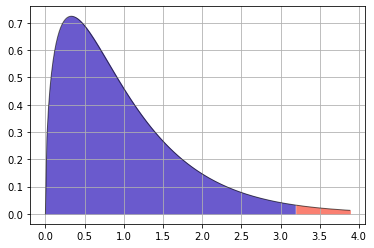

In [7]:
params = dict(zip(["dfn", "dfd", "lb", "ub", "decimals"], [3, 196, 0, 0.975, 3]))

prob_calc_f = rsm.ProbabilityCalculator("F", params)
prob_calc_f.calculate()
prob_calc_f.plot()

Probability calculator
Distribution: t
Df:	196
Mean:	0.0
St. dev:	1.005
Lower bound:	0.025
Upper bound:	0.975

P(X < -1.972) = 0.025
P(X > -1.972) = 0.975
P(X < 1.972) = 0.975
P(X > 1.972) = 0.025
P(-1.972 < X < 1.972) = 0.95
1 - P(-1.972 < X < 1.972 = 0.05


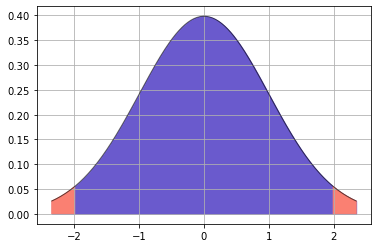

In [8]:
params = dict(zip(["df", "lb", "ub", "decimals"], [196, 0.025, 0.975, 3]))

prob_calc_t = rsm.ProbabilityCalculator("t", params)
prob_calc_t.calculate()
prob_calc_t.plot()

### Example 2: Ideal data for regression

The data `ideal` contains simulated data that is very useful to demonstrate what data for, and residuals from, a regression should ideally look like. The data has 1,000 observations on 4 variables. `y` is the response variable and `x1`, `x2`, and `x3` are explanatory variables. The plots shown below can be used as a bench mark for regressions on real world data

In [9]:
rsm.load_data(pkg="model", name="ideal", dct=globals())

In [10]:
rsm.describe(ideal)

## 'Ideal' data for regression

### Description

Simulated data set used to illustrate evaluation of regression residuals.  

### Variables

A data frame with 1000 observations on 4 variables (y, x1, x2, and x3)

In [11]:
evars = ["x1", "x2", "x3"]
rvar = "y"

In [12]:
fitted = rsm.regress(ideal, evars=evars, rvar=rvar)

Data:  'ideal'
Response variable    : y
Explanatory variables: x1, x2, x3
Null hyp.: the effect of x on y is zero
Alt. hyp.: the effect of x on y is not zero

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1361.
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        18:24:40   Log-Likelihood:                -2100.2
No. Observations:                1000   AIC:                             4208.
Df Residuals:                     996   BIC:                             4228.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

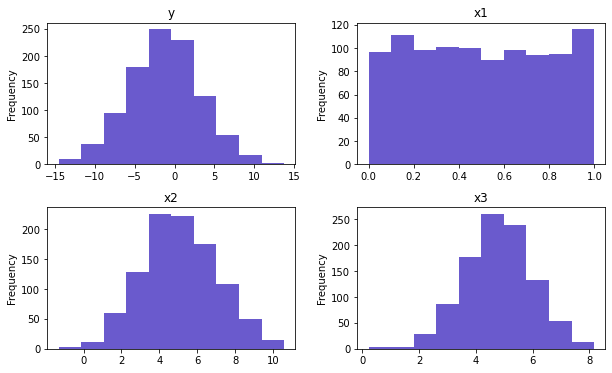

In [13]:
rsm.distr_plot(ideal)

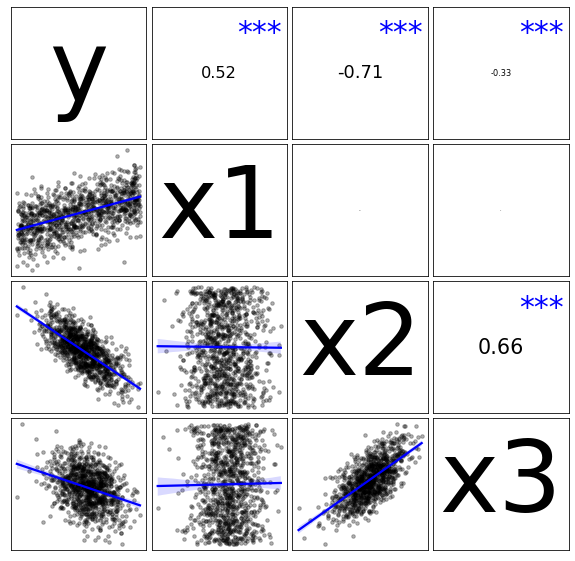

In [14]:
cr = rsm.correlation(ideal[["y", "x1", "x2", "x3"]])
cr.plot(nobs=-1, figsize=(10, 10))

In [15]:
def undummify(df: pd.DataFrame, prefix_sep: str = "__") -> Tuple[pd.DataFrame, bool]:
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    if not any(cols2collapse.values()):
        return df, False

    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df, True

In [16]:
def scatter_plot(fitted, nobs: int = 1000, figsize: tuple = None) -> None:
    # TODO: this has some bug when dealing with the plotting of categorical variables
    """
    Scatter plot of explanatory and response variables from a fitted regression

    Parameters
    ----------
    nobs : int
        Number of observations to use for the scatter plots. The default
        value is 1,000. To use all observations in the plots, use nobs=-1
    figsize : tuple
        A tuple that determines the figure size. If None, size is
        determined based on the number of variables in the model
    """

    endog = fitted.model.endog
    exogs = fitted.model.exog

    exog_names = fitted.model.exog_names
    endog_name = fitted.model.endog_names

    df = pd.DataFrame(exogs, columns=exog_names)
    df, was_undummified = undummify(df)
    df.drop("const", axis=1, inplace=True)
    exog_names = df.columns.to_list()
    if was_undummified:
        exog_names.remove(endog_name)
        endog = df[endog_name].to_numpy()
        exogs = df[exog_names].to_numpy()

    num_exog = len(exog_names)
    num_rows = math.ceil(num_exog / 2)

    if figsize is None:
        figsize = (num_rows * 5, max(5, min(num_exog, 2) * 5))

    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    # plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    idx = 0

    if nobs < fitted.model.endog.shape[0] and nobs != np.Inf and nobs != -1:
        df[endog_name] = endog

        df = df.copy().sample(nobs)

        endog = df[endog_name].to_numpy()
        exogs = df[exog_names].to_numpy()

    while idx < num_exog:
        row = idx // 2
        col = idx % 2
        exog_name = exog_names[idx]
        exog = [row[idx] for row in exogs]

        if num_rows > 1:
            axes[row][col].set_xlabel(exog_name)
            axes[row][col].set_ylabel(endog_name)
            axes[row][col].scatter(exog, endog)
        else:
            axes[col].set_xlabel(exog_name)
            axes[col].set_ylabel(endog_name)
            axes[col].scatter(exog, endog)
        idx += 1

    if (df.shape[1] - 1) % 2 != 0:
        if num_rows > 1:
            fig.delaxes(axes[row][1])  # remove last empty plot
        else:
            fig.delaxes(axes[1])

    plt.show()

In [17]:
def residual_vs_explanatory_plot(
    fitted: statsmodels.regression.linear_model.RegressionResults,
    nobs: int = 1000,
    figsize: tuple = None,
) -> None:
    # TODO: this has some bug when dealing with the plotting of categorical variables

    exogs = fitted.model.exog

    exog_names = fitted.model.exog_names
    endog_name = fitted.model.endog_names

    df = pd.DataFrame(exogs, columns=exog_names)
    df, was_undummified = undummify(df)
    df.drop("const", axis=1, inplace=True)
    true_exog_names = df.columns.to_list()
    if was_undummified:
        true_exog_names.remove(endog_name)

    num_exog = len(true_exog_names)
    num_rows = math.ceil(num_exog / 2)

    if figsize is None:
        figsize = (num_rows * 5, max(5, min(num_exog, 2) * 5))

    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    idx = 0

    residuals = fitted.resid

    data = pd.DataFrame(exogs, columns=exog_names)
    data, _ = undummify(data)

    data["residuals"] = residuals

    if nobs < fitted.model.endog.shape[0] and nobs != np.Inf and nobs != -1:
        data = data.copy().sample(nobs)

    categorical_dtypes = ['object', 'category', 'bool']

    while idx < num_exog:
        row = idx // 2
        col = idx % 2
        exog_name = true_exog_names[idx]
        exog = [row[idx] for row in exogs]

        if num_rows > 1:
            if data[exog_name].dtype.name in categorical_dtypes:
                sns.stripplot(
                    x=exog_name,
                    y="residuals",
                    data=data,
                    ax=axes[row][col],
                    c="black",
                ).set(xlabel=exog_name, ylabel="Residuals")
            else:
                sns.regplot(
                    x=exog_name,
                    y="residuals",
                    data=data,
                    ax=axes[row][col],
                    scatter_kws={"color": "black"},
                ).set(xlabel=exog_name, ylabel="Residuals")
        else:
            if data[exog_name].dtype.name in categorical_dtypes:
                sns.stripplot(
                    x=exog_name,
                    y="residuals",
                    data=data,
                    ax=axes[col],
                    c="black",
                ).set(xlabel=exog_name, ylabel="Residuals")
            else:
                sns.regplot(
                    x=exog_name,
                    y="residuals",
                    data=data,
                    ax=axes[col],
                    scatter_kws={"color": "black"},
                ).set(xlabel=exog_name, ylabel="Residuals")
        idx += 1

    if (df.shape[1] - 1) % 2 != 0:
        if num_rows > 1:
            fig.delaxes(axes[row][1])   # remove last empty plot
        else:
            fig.delaxes(axes[1])        # remove last empty plot
    plt.show()

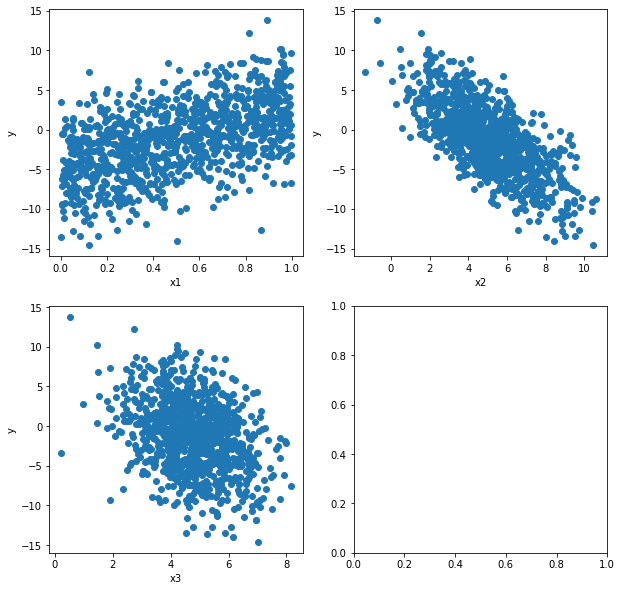

In [18]:
scatter_plot(fitted)

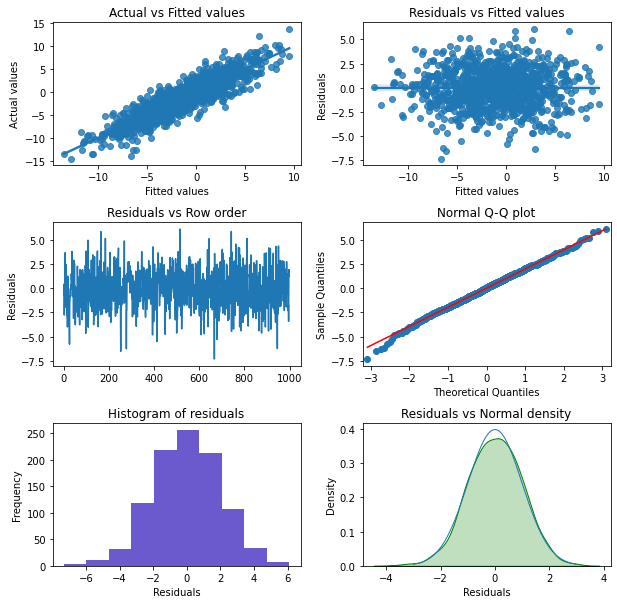

In [19]:
rsm.reg_dashboard(fitted=fitted, nobs=-1)

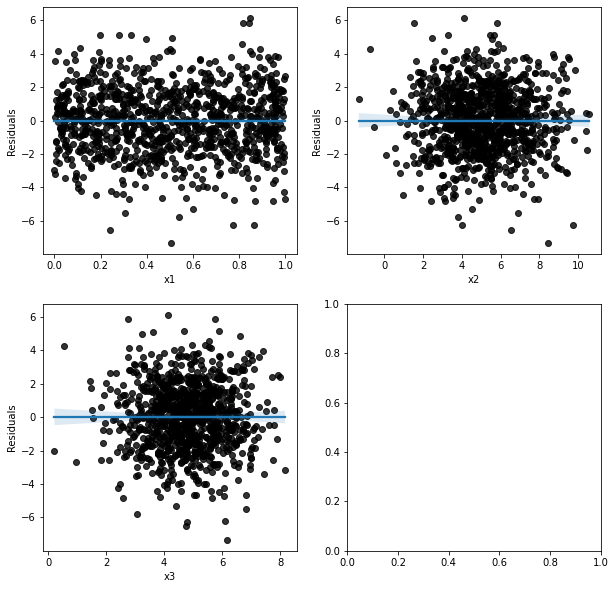

In [20]:
residual_vs_explanatory_plot(fitted)

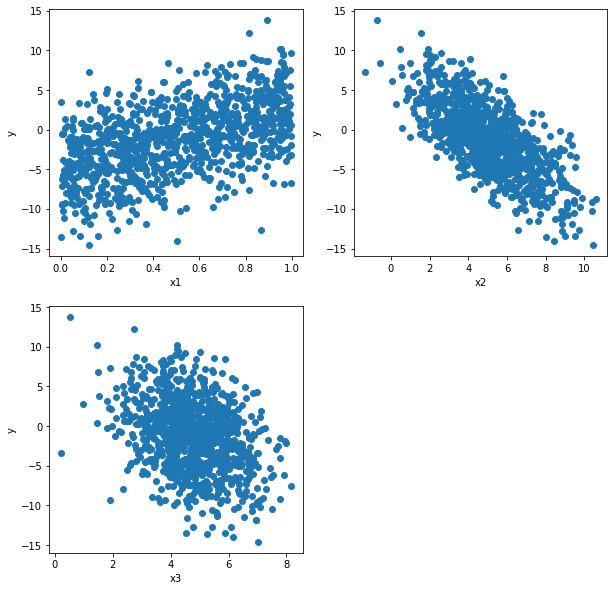

In [21]:
scatter_plot(fitted)

### Example 3: Linear or log-log regression?

Both linear and log-log regressions are commonly applied to business data. In this example we will look for evidence in the data and residuals that may suggest which model specification is  appropriate for the available data.

In [22]:
rsm.load_data(pkg="data", name="diamonds", dct=globals())

In [23]:
rsm.describe(diamonds)

## Diamond prices

Prices of 3,000 round cut diamonds

### Description

A dataset containing the prices and other attributes of a sample of 3000 diamonds. The variables are as follows:

### Variables

- price = price in US dollars ($338--$18,791)
- carat = weight of the diamond (0.2--3.00)
- clarity = a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- cut = quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color = diamond color, from J (worst) to D (best)
- depth = total depth percentage = z / mean(x, y) = 2 * z / (x + y) (54.2--70.80)
- table = width of top of diamond relative to widest point (50--69)
- x = length in mm (3.73--9.42)
- y = width in mm (3.71--9.29)
- z = depth in mm (2.33--5.58)
- date = shipment date

### Additional information

<a href="http://www.diamondse.info/diamonds-clarity.asp" target="_blank">Diamond search engine</a>


In [24]:
import matplotlib.pyplot as plt
from typing import List
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

import statsmodels
import statsmodels.api as sm

In [25]:
def distr_plot(df, nint=25, cols: List = None, **kwargs):
    """
    Plot histograms for numeric variables and frequency plots for categorical.
    variables. Columns of type integer with less than 25 unique values will be
    treated as categorical. To change this behavior, increase or decrease the
    value of the 'nint' argument

    Parameters
    ----------
    df : Pandas dataframe
    nint: int
        The number of unique values in a series of type integer below which the
        series will be treated as a categorical variable
    cols: A list of column names which indicate the subset of variables whose distribution needs to be plotted
    **kwargs : Named arguments to be passed to the pandas plotting methods
    """
    if cols != None:
        df = df[cols]

    fig, axes = plt.subplots(
        math.ceil(df.shape[1] / 2), 2, figsize=(10, 1.5 * df.shape[1])
    )
    plt.subplots_adjust(wspace=0.25, hspace=0.3)
    row = 0
    for i, c in enumerate(df.columns):
        s = df[c]
        j = rsm.ifelse(i % 2 == 0, 0, 1)
        if pd.api.types.is_integer_dtype(s.dtype) and s.nunique() < nint:
            s.value_counts(sort=False).plot.bar(
                ax=axes[row, j], title=c, rot=0, color="slateblue", **kwargs
            )
        elif pd.api.types.is_numeric_dtype(s.dtype):
            s.plot.hist(ax=axes[row, j], title=c, rot=0, color="slateblue", **kwargs)
        elif pd.api.types.is_categorical_dtype(s.dtype):
            s.value_counts(sort=False).plot.bar(
                ax=axes[row, j], title=c, rot=0, color="slateblue", **kwargs
            )
        else:
            print(f"No plot for {c} (type {s.dtype})")

        if j == 1:
            row += 1

    if df.shape[1] % 2 != 0:
        fig.delaxes(axes[row][1])  # remove last empty plot

    plt.show()

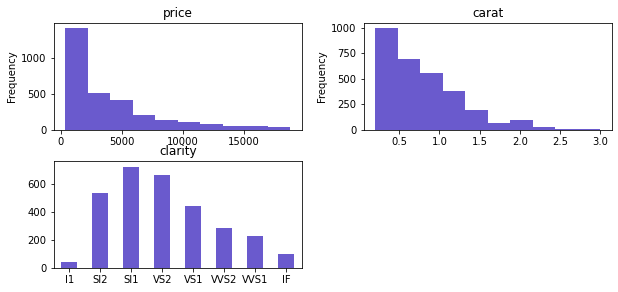

In [26]:
distr_plot(diamonds, cols=["price", "carat", "clarity"])

In [27]:
class correlation:
    def __init__(self, df):
        """
        Calculate correlations between numeric variables in a Pandas dataframe

        Parameters
        ----------
        df : Pandas dataframe with numeric variables

        Returns
        -------
        Correlation object with two key attributes
        cr: Correlation matrix
        cp: p.value matrix

        Examples
        --------
        import pandas as pd
        import pyrsm as rsm
        rsm.load_data(pkg="basics", name="salary", dct=globals())
        cr = rsm.correlation(salary[["salary", "yrs.since.phd", "yrs.service"]])
        c.cr
        """
        df = df.copy()
        isNum = [
            col for col in df.columns if pd.api.types.is_numeric_dtype(df[col].dtype)
        ]
        df = df[isNum]

        ncol = df.shape[1]
        cr = np.zeros([ncol, ncol])
        cp = cr.copy()
        for i in range(ncol - 1):
            for j in range(i + 1, ncol):
                cdf = df.iloc[:, [i, j]]
                # pairwise deletion
                cdf = cdf[~np.any(np.isnan(cdf), axis=1)]
                c = stats.pearsonr(cdf.iloc[:, 0], cdf.iloc[:, 1])
                cr[j, i] = c[0]
                cp[j, i] = c[1]

        self.df = df
        self.cr = cr
        self.cp = cp

    def summary(self, cutoff=0, dec=2):
        """
        Print correlations between numeric variables in a Pandas dataframe

        Parameters
        ----------
        cutoff : float
            Only show correlations larger than a threshold in absolute value
        dec : int
            Number of decimal places to use in rounding

        Examples
        --------
        import pandas as pd
        import pyrsm as rsm
        rsm.load_data(pkg="basics", name="salary", dct=globals())
        cr = rsm.correlation(salary[["salary", "yrs.since.phd", "yrs.service"]])
        cr.summary()
        """
        ind = np.triu_indices(self.cr.shape[0])
        cn = self.df.columns[:-1]
        indn = self.df.columns[1:]

        # correlations
        crs = self.cr.round(dec).astype(str)
        if cutoff > 0:
            crs[np.abs(self.cr) < cutoff] = ""
        crs[ind] = ""
        crs = pd.DataFrame(
            np.delete(np.delete(crs, 0, axis=0), crs.shape[1] - 1, axis=1),
            columns=cn,
            index=indn,
        )

        # pvalues
        cps = self.cp.round(dec).astype(str)
        if cutoff > 0:
            cps[np.abs(self.cr) < cutoff] = ""
        cps[ind] = ""
        cps = pd.DataFrame(
            np.delete(np.delete(cps, 0, axis=0), cps.shape[1] - 1, axis=1),
            columns=cn,
            index=indn,
        )

        cn = self.df.columns
        if len(cn) > 2:
            x = "x"
            y = "y"
        else:
            x = cn[0]
            y = cn[1]

        prn = "Correlation\n"
        prn += "Variables: " + ", ".join(list(self.df.columns)) + "\n"
        prn += f"Null hyp.: variables {x} and {y} are not correlated\n"
        prn += f"Alt. hyp.: variables {x} and {y} are correlated\n"
        print(prn)
        print("Correlation matrix:")
        print(crs)
        print("\np.values:")
        print(cps)

    def plot(self, nobs=1000, dec=2, figsize=None):
        """
        Plot of correlations between numeric variables in a Pandas dataframe

        Parameters
        ----------
        nobs : int
            Number of observations to use for the scatter plots. The default
            value is 1,000. To use all observations in the plots, use nobs=-1
        dec : int
            Number of decimal places to use in rounding
        figsize : tuple
            A tuple that determines the figure size. If None, size is
            determined based on the number of numeric variables in the
            data

        Examples
        --------
        import pandas as pd
        import pyrsm as rsm
        rsm.load_data(pkg="basics", name="salary", dct=globals())
        cr = rsm.correlation(salary[["salary", "yrs.since.phd", "yrs.service"]])
        cr.plot(figsize=(7, 3))
        """

        def cor_label(label, longest, ax_sub):
            ax_sub.axes.xaxis.set_visible(False)
            ax_sub.axes.yaxis.set_visible(False)
            # set font size to avoid exceeding boundaries
            font = (80 * self.fig_size) / (len(longest) * len(self.df.columns))
            ax_sub.text(
                0.5,
                0.5,
                label,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=font,
            )

        def cor_text(r, p, ax_sub, dec=2):
            if np.isnan(p):
                p = 1

            p = round(p, dec)
            rt = round(r, dec)
            p_star = rsm.sig_stars([p])[0]

            font = (50 * self.fig_size) / (len(str(rt)) * len(self.df.columns))
            font_star = (12 * self.fig_size) / len(self.df.columns)

            ax_sub.axes.xaxis.set_visible(False)
            ax_sub.axes.yaxis.set_visible(False)
            ax_sub.text(
                0.5,
                0.5,
                rt,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=font * abs(r),
            )
            ax_sub.text(
                0.8,
                0.8,
                p_star,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=font_star,
                color="blue",
            )

        def cor_plot(x_data, y_data, ax_sub, s_size):
            sns.regplot(
                x=x_data,
                y=y_data,
                ax=ax_sub,
                scatter_kws={"alpha": 0.3, "color": "black", "s": s_size},
                line_kws={"color": "blue"},
            )

            ax_sub.axes.xaxis.set_visible(False)
            ax_sub.axes.yaxis.set_visible(False)

        def cor_mat(df, cmat, pmat, dec=2, nobs=1000, figsize=None):

            cn = df.columns
            ncol = len(cn)
            print(f"number of columns: {ncol}")
            longest = max(cn, key=len)
            s_size = 50 / len(self.df.columns)

            if figsize is None:
                figsize = (max(5, cmat.shape[0]), max(cmat.shape[0], 5))

            self.fig_size = min(figsize[0], figsize[1])
            s_size = (5 * self.fig_size) / len(self.df.columns)

            fig, axes = plt.subplots(ncol, ncol, figsize=figsize)

            if nobs < df.shape[0] and nobs != np.Inf and nobs != -1:
                df = df.copy().sample(nobs)

            for i in range(ncol):
                for j in range(ncol):
                    if i == j:
                        print(f"label: {cn[i]}")
                        cor_label(cn[i], longest, axes[i, j])
                    elif i > j:
                        print(f"plot of {cn[i]} vs {cn[j]}")
                        cor_plot(df[cn[i]], df[cn[j]], axes[i, j], s_size)
                    else:
                        cor_text(cmat[j, i], pmat[j, i], axes[i, j], dec=2)

            plt.subplots_adjust(wspace=0.04, hspace=0.04)
            plt.show()

        cor_mat(self.df, self.cr, self.cp, dec=dec, nobs=nobs, figsize=figsize)

In [28]:
diamonds.columns

Index(['price', 'carat', 'clarity', 'cut', 'color', 'depth', 'table', 'x', 'y',
       'z', 'date'],
      dtype='object')

number of columns: 2
label: price
plot of carat vs price
label: carat


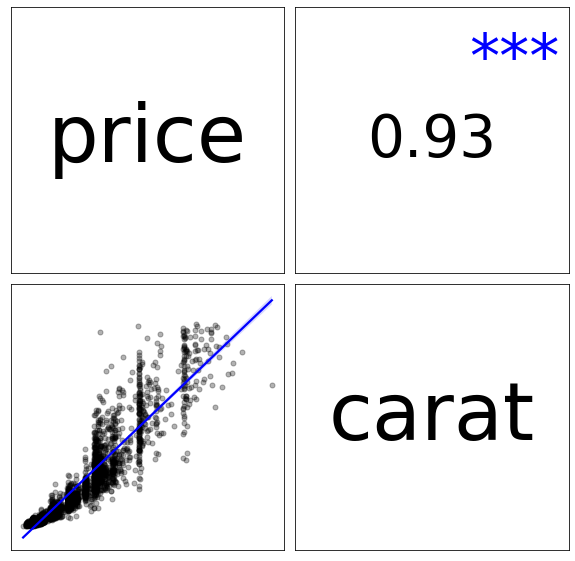

In [29]:
cr = correlation(diamonds[["price", "carat", "clarity"]])
cr.plot(nobs=-1, figsize=(10, 10))

In [30]:
def regress(
    dataset: pd.DataFrame,
    rvar: str = None,
    evars: List[str] = None,
    form: str = "",
    ssq: bool = False,
) -> statsmodels.regression.linear_model.RegressionResults:
    """
    Estimate linear regression model

    Parameters
    ----------
    dataset: pandas dataframe; dataset
    evars: list of strings; contains the names of the columns of data to be used as explanatory variables
    rvar: string; name of the column which is to be used as the response variable
    form: string; formula for the regression equation

    Returns
    -------
    res: Object with fitted values and residuals
    """
    dataset_cols = evars.copy()
    dataset_cols.append(rvar)
    dataset = dataset[dataset_cols]

    categorical_dtypes = ["object", "category", "bool"]

    categorical_vars = [
        col for col in dataset.columns if dataset[col].dtype.name in categorical_dtypes
    ]

    if len(categorical_vars) > 0:
        print(f"there are categorical values: {categorical_vars}")
        dataset = pd.get_dummies(
            data=dataset, prefix_sep="__", columns=categorical_vars, drop_first=True
        )
        evars = dataset.columns.to_list()

    if form != "":
        model = sm.ols(form, data=dataset)
        evars = rsm.setdiff(model.exog_names, "const")
        rvar = model.endog_names
    else:
        evars_df = sm.add_constant(dataset[evars], prepend=False)
        model = sm.OLS(dataset[rvar], evars_df)

    res = model.fit()

    data_name = ""
    if hasattr(dataset, "description"):
        data_name = dataset.description.split("\n")[0].split()[1].lower()

    print("Data: ", data_name)
    print("Response variable    :", rvar)
    print("Explanatory variables:", ", ".join(evars))
    print(f"Null hyp.: the effect of x on {rvar} is zero")
    print(f"Alt. hyp.: the effect of x on {rvar} is not zero")
    summary = res.summary()
    summary.tables.pop()  # gets rid of the last table in res.summary(), we don't need it
    print("\n", summary)

    if ssq:
        print("Sum of squares")
        index = ["Regression", "Error", "Total"]
        sum_of_squares = [res.ess, res.ssr, res.centered_tss]
        sum_of_squares_series = pd.Series(
            data=rsm.format_nr(sum_of_squares, dec=0), index=index
        )
        print(f"\n{sum_of_squares_series.to_string()}")

    return res

In [31]:
fitted = regress(diamonds, rvar="price", evars=["carat", "clarity"])

there are categorical values: ['clarity']
Data:  
Response variable    : price
Explanatory variables: carat, price, clarity__SI2, clarity__SI1, clarity__VS2, clarity__VS1, clarity__VVS2, clarity__VVS1, clarity__IF
Null hyp.: the effect of x on price is zero
Alt. hyp.: the effect of x on price is not zero

                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.032e+32
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        18:24:46   Log-Likelihood:                 76011.
No. Observations:                3000   AIC:                        -1.520e+05
Df Residuals:                    2990   BIC:                        -1.519e+05
Df Model:                           9                       

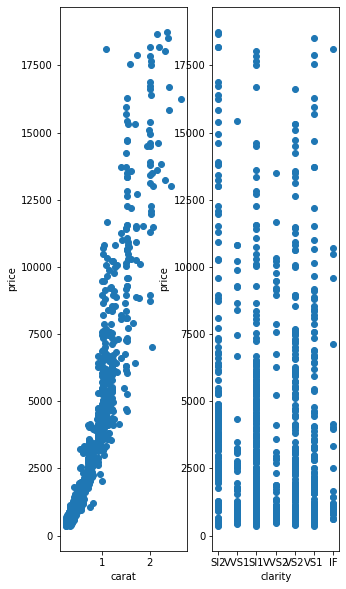

In [32]:
scatter_plot(fitted)

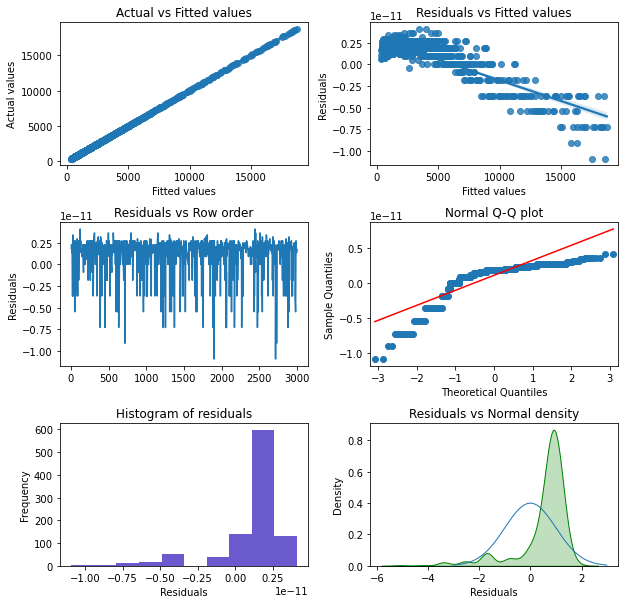

In [33]:
rsm.reg_dashboard(fitted) # not sure why this is different from the one at https://radiant-rstats.github.io/docs/model/regress.html

float64
object


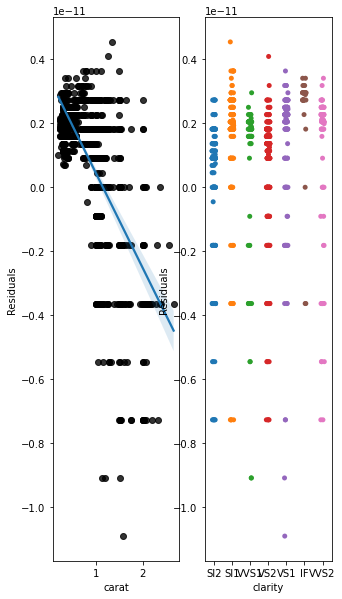

In [34]:
residual_vs_explanatory_plot(fitted)

In [37]:
from math import log

In [38]:
class Transform:
    def __init__(
        self, data: pd.DataFrame, cols: List[str], transform_type: str
    ) -> None:
        self.transform_type = transform_type
        self.data = data
        self.cols = cols

    def transform(self) -> pd.DataFrame:
        if self.transform_type == "ln":
            return self.transform_ln()

    def transform_ln(self, base: int = None) -> pd.DataFrame:
        new_cols = {
            col: col + "_ln" if col in self.cols else col for col in self.data.columns
        }
        for old_col in self.cols:
            if base != None:
                self.data[old_col] = self.data[old_col].transform(log, base)
            else:
                self.data[old_col] = self.data[old_col].transform(log)

        self.data.rename(new_cols, axis=1, inplace=True)
        return self.data

In [39]:
tf = Transform(diamonds, ["price", "carat"], "ln")
diamonds_ln = tf.transform()

In [40]:
diamonds_ln

,price_ln,carat_ln,clarity,cut,color,depth,table,x,y,z,date
0,6.363028,-1.139434,VS1,Ideal,H,61.0,56.0,4.43,4.45,2.71,2012-02-26
1,6.476972,-1.078810,SI1,Very Good,G,63.4,57.0,4.45,4.42,2.81,2012-02-26
2,6.445720,-1.203973,VS2,Very Good,G,63.1,58.0,4.27,4.23,2.68,2012-02-26
3,6.559615,-1.049822,VVS2,Ideal,H,59.2,56.0,4.60,4.65,2.74,2012-02-26
4,6.984716,-0.916291,VS2,Premium,F,62.6,58.0,4.72,4.68,2.94,2012-02-26
...,...,...,...,...,...,...,...,...,...,...,...
2995,8.336390,0.131028,SI1,Very Good,J,63.3,55.0,6.60,6.67,4.20,2015-12-01
2996,9.035511,0.412110,SI1,Ideal,I,61.2,60.0,7.39,7.37,4.52,2015-12-01
2997,6.107023,-1.139434,VS2,Premium,I,62.6,58.0,4.37,4.42,2.75,2015-12-01
2998,8.382518,-0.094311,VS1,Very Good,H,62.1,59.0,6.17,6.20,3.84,2015-12-01


In [43]:
def scatter(
    df: pd.DataFrame,
    col1: str,
    col2: str,
    figsize: Tuple[int, int] = (10, 10),
) -> None:
    _, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.scatter(df[col1], df[col2])

    plt.show()

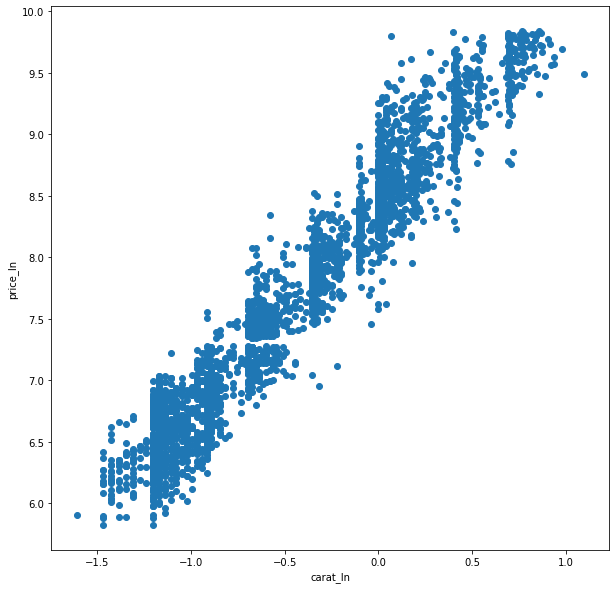

In [44]:
scatter(diamonds_ln, "carat_ln", "price_ln")

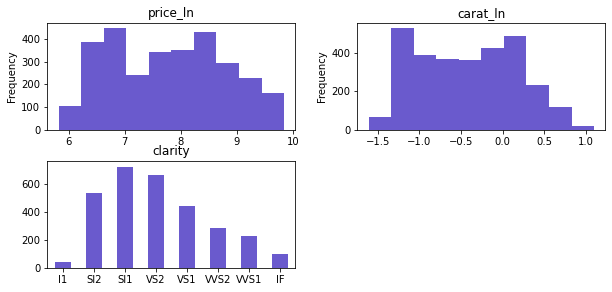

In [46]:
distr_plot(diamonds_ln, cols=["price_ln", "carat_ln", "clarity"])

number of columns: 2
label: price_ln
plot of carat_ln vs price_ln
label: carat_ln


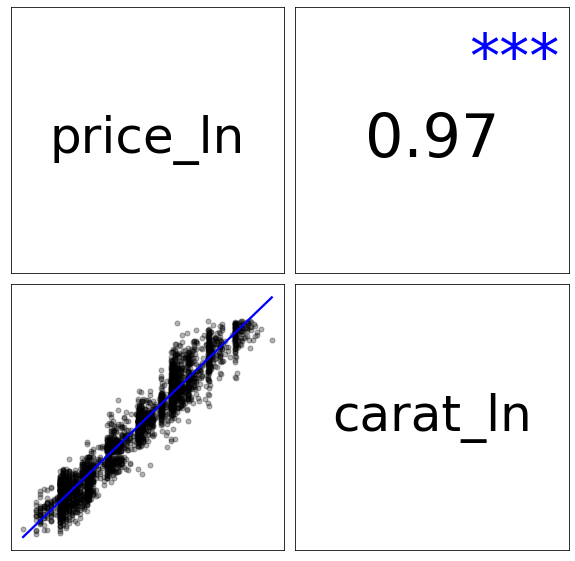

In [47]:
cr = correlation(diamonds_ln[["price_ln", "carat_ln", "clarity"]])
cr.plot(nobs=-1, figsize=(10, 10))

In [48]:
fitted = regress(diamonds_ln, rvar="price_ln", evars=["carat_ln", "clarity"])

there are categorical values: ['clarity']
Data:  
Response variable    : price_ln
Explanatory variables: carat_ln, price_ln, clarity__SI2, clarity__SI1, clarity__VS2, clarity__VS1, clarity__VVS2, clarity__VVS1, clarity__IF
Null hyp.: the effect of x on price_ln is zero
Alt. hyp.: the effect of x on price_ln is not zero

                             OLS Regression Results                            
Dep. Variable:               price_ln   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.230e+30
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        19:08:01   Log-Likelihood:                 92766.
No. Observations:                3000   AIC:                        -1.855e+05
Df Residuals:                    2990   BIC:                        -1.855e+05
Df Model:                           9        

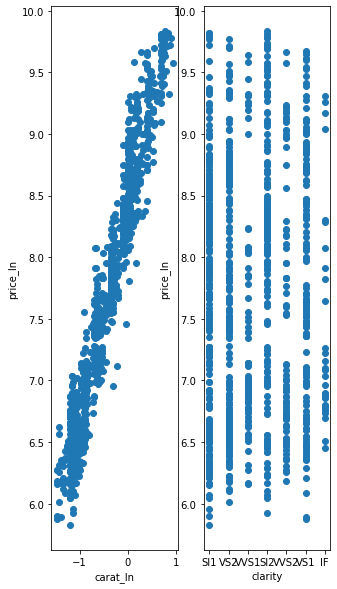

In [49]:
scatter_plot(fitted)

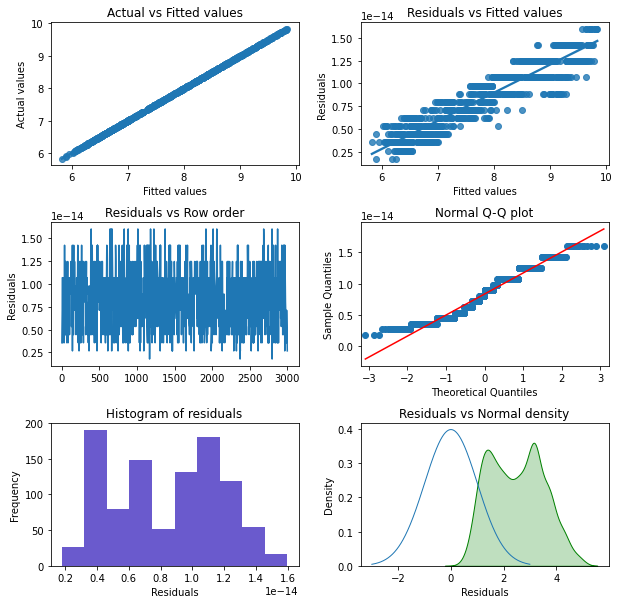

In [50]:
rsm.reg_dashboard(fitted)

float64
object


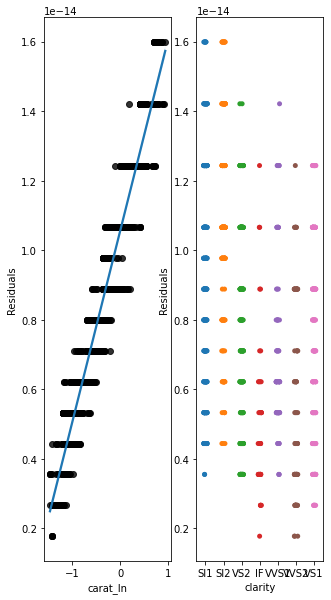

In [51]:
residual_vs_explanatory_plot(fitted)